# Lecture : Graph Clustering

## Lab 03 : Metis 

### Xavier Bresson  


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pip install pymetis==2023.1 # install metis 
    !pip install dgl==2.1.0 # install dgl
    !pwd
    

In [2]:
# Data conversion used in this notebook
#  from DGL to networkx :                          G_nx = dgl.to_networkx(G_dgl)
#  from scipy.sparse._csc.csc_matrix to DGL :      G_dgl = dgl.from_scipy(G_sp)
#  from scipy.sparse._csc.csc_matrix to networkx : G_nx = nx.from_scipy_sparse_array(G_sp)
#  from networkx to numpy :                        G_np = nx.to_numpy_array(G_nx)


In [3]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2
from lib.utils import compute_purity
import warnings; warnings.filterwarnings("ignore")
from lib.utils import nldr_visualization
import os
import torch
import networkx as nx
import dgl # DGL
import pymetis # PyG Metis


# Artifical balanced graph

Graph(num_nodes=9, num_edges=22,
      ndata_schemes={}
      edata_schemes={})
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
(tensor([0, 0, 1, 3, 3, 4, 6, 6, 7, 1, 2, 2, 1, 2, 4, 5, 5, 7, 8, 8, 7, 3]), tensor([2, 1, 2, 4, 5, 5, 7, 8, 8, 7, 3, 0, 0, 1, 3, 3, 4, 6, 6, 7, 1, 2]))


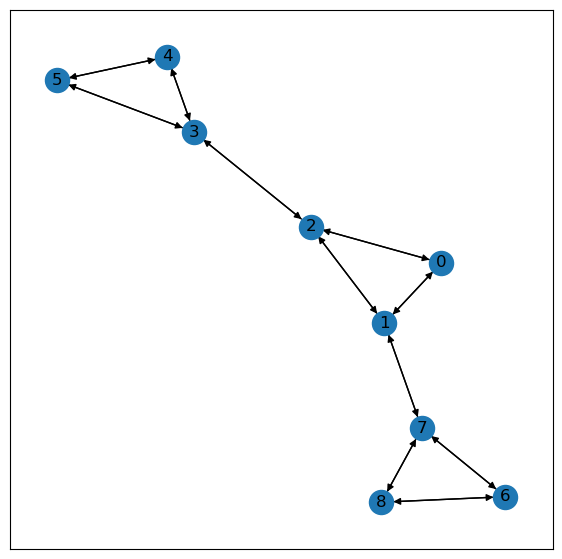

In [4]:
# Build a simple artificail graph of 3 balanced communities with DGL
r = torch.LongTensor([0, 0, 1, 3, 3, 4, 6, 6, 7, 1, 2])
c = torch.LongTensor([2, 1, 2, 4, 5, 5, 7, 8, 8, 7, 3])
n = 9
G_dgl = dgl.graph((r,c), num_nodes=n)
G_dgl = dgl.add_reverse_edges(G_dgl) # undirected graph
print(G_dgl)
print(G_dgl.nodes())
print(G_dgl.edges())

# Plot graph
G_nx = dgl.to_networkx(G_dgl)
plt.figure(figsize=[7,7])
nx.draw_networkx(G_nx, with_labels=True)


Convert a graph into a bidirected graph: 0.000 seconds, peak memory: 0.000 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 0.000 GB
Metis partitioning: 0.000 seconds, peak memory: 0.000 GB
C_metis_dgl tensor([0, 0, 0, 2, 2, 2, 1, 1, 1])


[12:45:41] /tmp/dgl_src/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 9 nodes and 22 edges into 3 parts and get 2 edge cuts


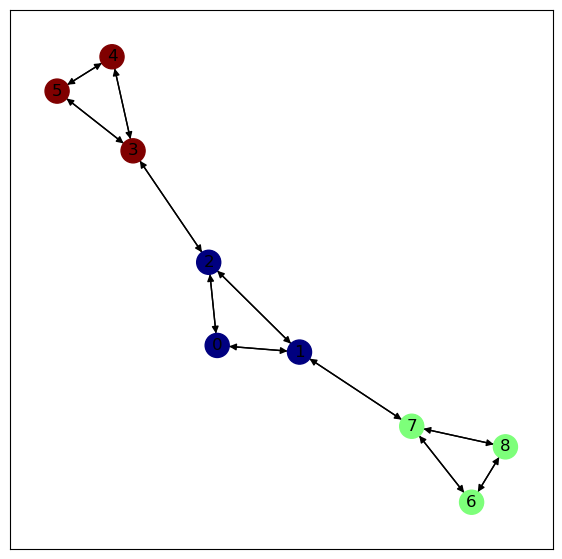

In [5]:
# Run Metis with DGL
#  https://docs.dgl.ai/en/0.8.x/generated/dgl.dataloading.ClusterGCNSampler.html

try: os.remove("cluster_gcn.pkl") # remove any existing partition
except: pass 
num_parts = 3
sampler = dgl.dataloading.ClusterGCNSampler(G_dgl, num_parts) 
C_metis_dgl = torch.zeros(G_dgl.num_nodes()).long()
for idx, (idx_start, idx_end) in enumerate(zip(sampler.partition_offset[:num_parts], sampler.partition_offset[1:num_parts+1])):
    C_metis_dgl[sampler.partition_node_ids[idx_start: idx_end]] = idx
print('C_metis_dgl',C_metis_dgl)
G_nx = dgl.to_networkx(G_dgl)
plt.figure(figsize=[7,7])
nx.draw_networkx(G_nx, with_labels=True, node_color=C_metis_dgl, cmap='jet')


C_metis_pyg tensor([1, 1, 1, 2, 2, 2, 0, 0, 0])


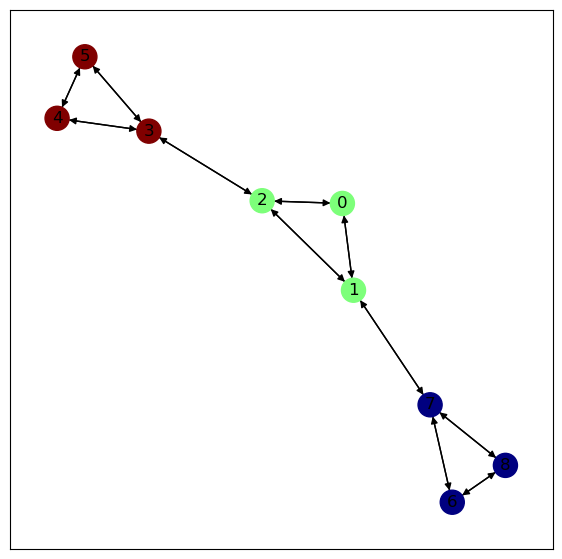

In [6]:
# Run Metis with PyG
#  https://github.com/inducer/pymetis/blob/master/pymetis/__init__.py

num_parts = 3
G_nx = dgl.to_networkx(G_dgl)
_, part_vert = pymetis.part_graph(num_parts, adjacency=G_nx)
C_metis_pyg = torch.tensor(part_vert).long()
print('C_metis_pyg',C_metis_pyg)
plt.figure(figsize=[7,7])
nx.draw_networkx(G_nx, with_labels=True, node_color=C_metis_pyg, cmap='jet')


# Real-world USPS image graph

In [7]:
# Load USPS Music dataset
mat = scipy.io.loadmat('datasets/USPS.mat')
W = mat['W'] # scipy.sparse._csc.csc_matrix
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt = Cgt.squeeze()
nc = len(np.unique(Cgt))
print('n,nc:',n,nc)


n,nc: 9298 10


In [8]:
# Run Metis with DGL
#  https://docs.dgl.ai/en/0.8.x/generated/dgl.dataloading.ClusterGCNSampler.html

try: os.remove("cluster_gcn.pkl") # remove any existing partition
except: pass 
num_parts = nc
G_dgl = dgl.from_scipy(W)
sampler = dgl.dataloading.ClusterGCNSampler(G_dgl, num_parts) 
C_metis_dgl = torch.zeros(G_dgl.num_nodes()).long()
for idx, (idx_start, idx_end) in enumerate(zip(sampler.partition_offset[:num_parts], sampler.partition_offset[1:num_parts+1])):
    C_metis_dgl[sampler.partition_node_ids[idx_start: idx_end]] = idx
print('C_metis_dgl',C_metis_dgl)
C_metis_dgl = np.array(C_metis_dgl, dtype='int32')
acc = compute_purity(C_metis_dgl, Cgt, nc)
print('\nAccuracy Metis DGL :',acc)


Convert a graph into a bidirected graph: 0.004 seconds, peak memory: 0.000 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 0.000 GB
Metis partitioning: 0.028 seconds, peak memory: 0.000 GB
C_metis_dgl tensor([1, 0, 0,  ..., 9, 9, 9])


[12:45:42] /tmp/dgl_src/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 9298 nodes and 146060 edges into 10 parts and get 6607 edge cuts



Accuracy Metis DGL : 81.10346311034631


In [9]:
# Run Metis with PyG
#  https://github.com/inducer/pymetis/blob/master/pymetis/__init__.py

num_parts = nc
G_nx = nx.from_scipy_sparse_array(W)
_, part_vert = pymetis.part_graph(num_parts, adjacency=G_nx)
C_metis_pyg = np.array(part_vert,dtype='int32')
acc = compute_purity(C_metis_pyg, Cgt, nc)
print('\nAccuracy Metis PyG :',acc)



Accuracy Metis PyG : 77.16713271671327


(9298,)


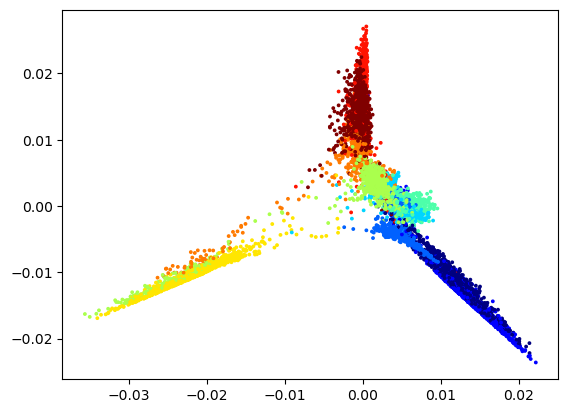

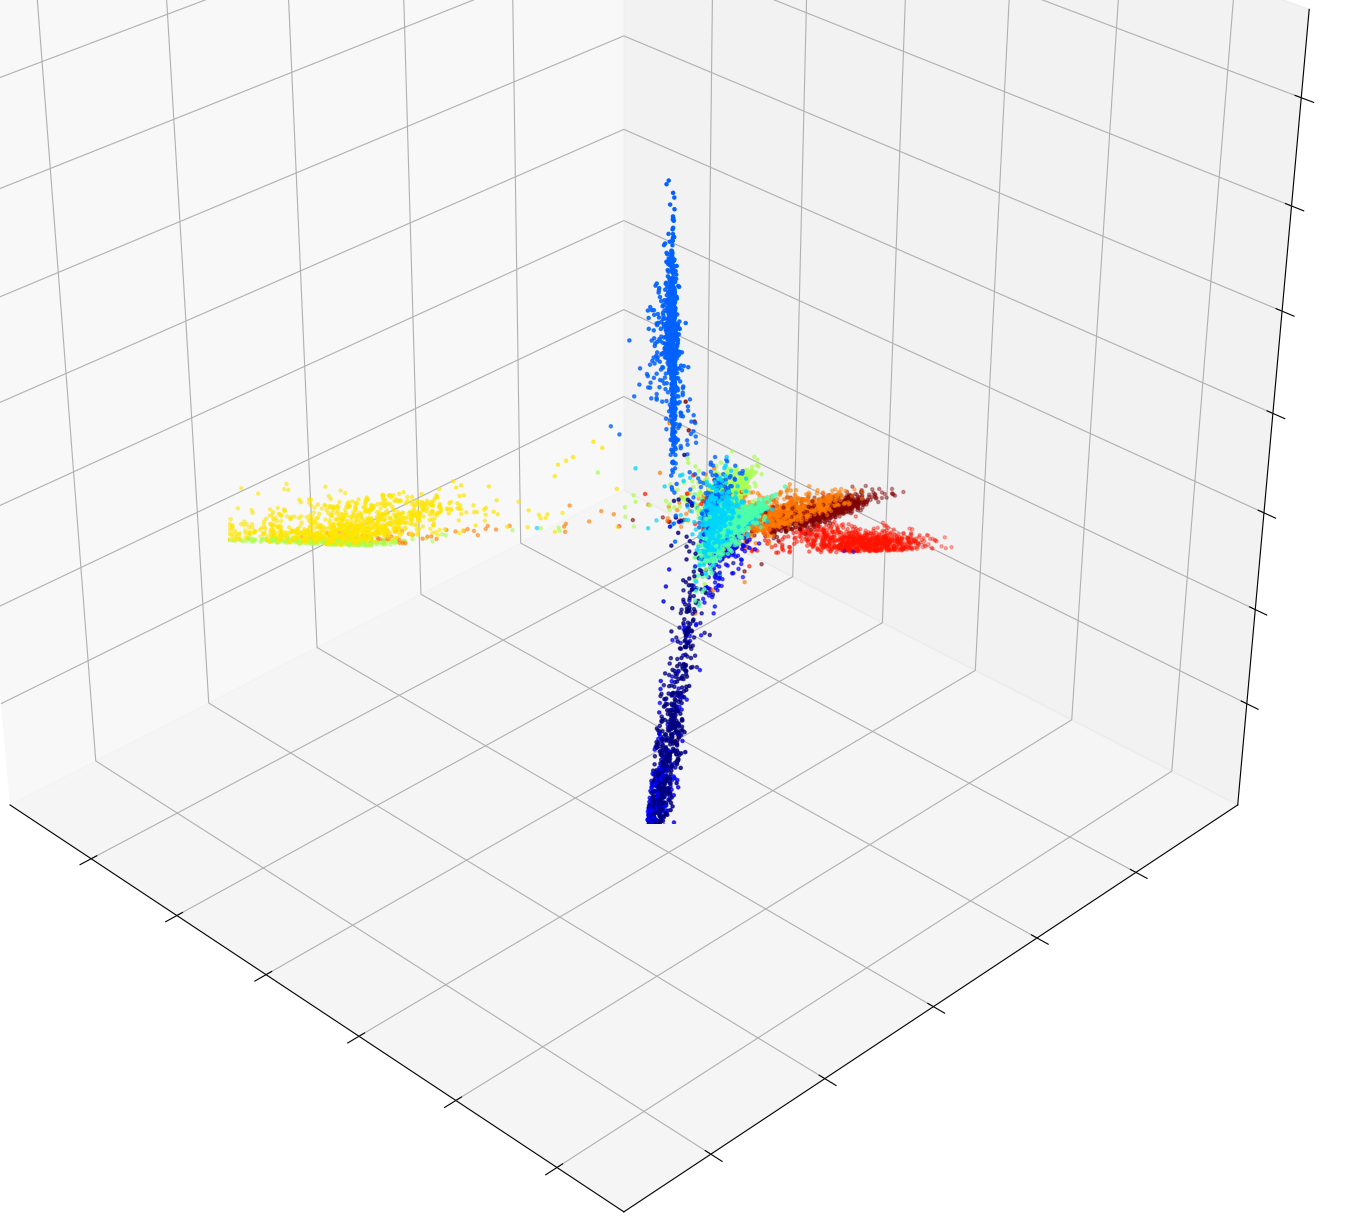

In [10]:
# Compute non-linear dim reduction
[X,Y,Z] = nldr_visualization(nx.to_numpy_array(G_nx))
#[X,Y,Z] = compute_non_linear_dim_reduction(nx.to_numpy_array(G_nx))
print(X.shape)

# 2D Visualization
plt.figure(3)
plt.scatter(X, Y, c=C_metis_dgl, s=3, color=pyplot.jet())
plt.show()

#  3D Visualization
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=C_metis_dgl, s=5)
ax.set_box_aspect((1, 1, 1), zoom=2)
#ax.set_axis_off()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.view_init(elev=30, azim=-45)
plt.show()
